<b> add your surname and name here!!!!!!</b>

##  SURNAME: ________ NAME: _________

In [3]:
import numpy as np
import cv2 as cv2
from scipy import signal
import matplotlib.pyplot as plt
from visualize_flow import flow_to_color
import time
%matplotlib inline


##  Lucas-Kanade optical flow algorithm

In this lab we deepen our understanding on the Lucas Kanade (LK) optical flow algorithm. 

<ol>
    <li>Part 1: we go into the <b>implementation details</b> of a single scale estimation (the one we saw in class) </li>
    <li>Part 2 (optional): we will use the <b>pre-implemented </b> algorithm (OpenCV) for a multi-resolution pyramidal version.</li>
</ol>
 
### Part1 - Single Scale LK 

In [26]:
# we start by loading a pair of adjacent frames
#img1= cv2.imread('Data/stennis/stennis_002.ppm',cv2.IMREAD_GRAYSCALE)
#img2= cv2.imread('Data/stennis/stennis_003.ppm',cv2.IMREAD_GRAYSCALE)
img1= cv2.imread('Data/sphere/sphere.12.ppm',cv2.IMREAD_GRAYSCALE)
img2= cv2.imread('Data/sphere/sphere.13.ppm',cv2.IMREAD_GRAYSCALE)

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))

<b> Fill in the missing details on the Lucas_Kanade function, after you analyse and understand what's already there: </b>

In [5]:
# this function computes the optical flow between 2 frames
# window_size controls the size of the pixel neighbourhood
# tau is a threshould on the "quality" of the neighbourhood (explained in class)

def Lucas_Kanade(im1,im2,window_size,tau):
    # spatio-temporal derivative kernels
    kernel_x = np.array([[-1., 1.], [-1., 1.]])*.25 
    kernel_y = np.array([[-1., -1.], [1., 1.]])*.25
    kernel_t = np.array([[1., 1.], [1., 1.]])*.25
    w = int(window_size/2) # window_size is odd, all the pixels with offset in between [-w, w] are inside the window
    I1g = im1 / 255. # normalize pixels
    I2g = im2 / 255. # normalize pixels
    # Implement Lucas Kanade
    # for each point, calculate I_x, I_y, I_t
    mode = 'same'
    fx = signal.convolve2d(I1g, kernel_x, boundary='symm', mode=mode)# + signal.convolve2d(I2g, kernel_x, boundary='symm', mode=mode)
    fy = signal.convolve2d(I1g, kernel_y, boundary='symm', mode=mode)# + signal.convolve2d(I2g, kernel_y, boundary='symm', mode=mode) 
    ft = signal.convolve2d(I1g, kernel_t, boundary='symm', mode=mode) +signal.convolve2d(I2g, -kernel_t, boundary='symm', mode=mode)
    u = np.zeros(I1g.shape)
    v = np.zeros(I1g.shape)
    # within window window_size * window_size
    
    # see slides (Optical Flow Algorithm) 
    for i in range(w, I1g.shape[0]-w):
        for j in range(w, I1g.shape[1]-w):
            Ix = fx[i-w:i+w+1, j-w:j+w+1].flatten()
            Iy = fy[i-w:i+w+1, j-w:j+w+1].flatten()
            It = np.array(ft[i-w:i+w+1, j-w:j+w+1].flatten())
            A = np.transpose(np.array([#...FILL IN....]))
            b = # FILL IN THIS LINE
            if np.min(abs(np.linalg.eigvals(np.matmul(A.T, A)))) >= tau: 
                nu = np.matmul(np.linalg.pinv(A), b)  # UNDERSTAND THIS LINE!
                u[i,j]=nu[0]
                v[i,j]=nu[1]
      

    return (u,v) #two components of the optical flow

Call the previously defined method

In [20]:
start = time.time()
[u,v] = Lucas_Kanade(img1,img2,7,0.001)
print("Elapsed time is %d"%(time.time()-start))

Elapsed time is 7


Let's visualize the results of the flow field. We may try the quiver function first

(240, 352)
(240, 352)


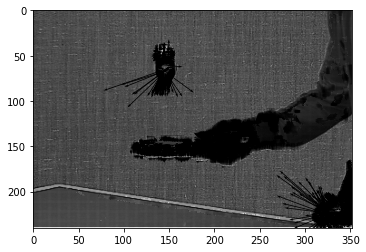

In [21]:
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
print(u.shape)
print(v.shape)
xaxis = list(np.arange(img1.shape[0]))
yaxis = list(np.arange(img1.shape[1]))
plt.xlim(0, 352)
plt.ylim(240,0)
plt.quiver(u,v)

In [86]:
plt.quiver??

We may also visualize the flow field using a color-coding algorithm ( See https://github.com/tomrunia/OpticalFlow_Visualization)

In [22]:
flow = np.stack([u,v],axis=2)
flow_color = flow_to_color(flow, convert_to_bgr=False)
plt.imshow(flow_color)

###   Analysis:

- Go back to the function Lucas_Kanade and a comment to explain each line of code  
- In particular, can you explain this? <tt> np.min(abs(np.linalg.eigvals(np.matmul(A.T, A)))) >= tau: </tt>

### Experiments:
- Try different window size and thresholds tau 
- Try different frames (also introducing some temporal gap between them)  
- Try both sphere and tennis datasets
- What do you observe ? Do you see any specific limits in the very simple LK method?


### Optional Part2 - Pyramidal LK
<i>We did not cover the Pyramidal extension during the OF class; this part should be considered as additional and optional material. </i>
<br>
Now let's take a look at the implementation provided in OpenCV of a pyramid Lucas-Kanade Sparse optical flow

The algorithm evaluates optical flow on sparse points (corners) in order to avoid the ill-posed inversion of A'A.
Additionally, Optical flow is calculated and combined on different scales to handle large-displacement

In [23]:
#parameters of the corner detection procedure
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.1,
                       minDistance = 7,
                       blockSize = 7 )

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))


1- Call the function that detects the key-points (Shi-Tomasi corners) from the first frame 
2- Call LK Flow algorithm which returns the positions of these key points in the second frame

In [24]:
p0 = cv2.goodFeaturesToTrack(img1, mask = None, **feature_params)
p1, st, err = cv2.calcOpticalFlowPyrLK(img1, img2, p0, None, **lk_params)

Draw vectors to connect points from the first frame and the second frame to visualize the motion vectors

(100, 2)


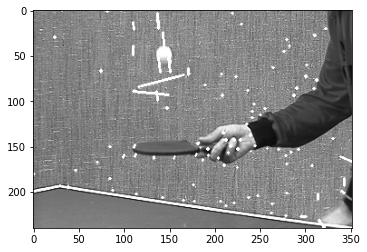

In [25]:
good_new = p1[st==1]
good_old = p0[st==1]
mask = np.zeros_like(img1)
print(good_old.shape)
for i,(new,old) in enumerate(zip(p1,p0)):
    a,b = np.int32(new.ravel())
    c,d = np.int32(old.ravel())
    mask = cv2.line(mask, (a,b),(c,d), [255,255,0], 2)
img2 = cv2.add(img2,mask)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
